# Introduction #

In the last lesson, we saw that a convolutional classifier has two parts: a **base** and a **head**. We learned that the job of the base is to extract visual features features from an image, which the head would then use to classify the image.

In this lesson, we'll learn how this convolutional base is constructed of **blocks** which perform **three basic operations** common to CNN image classifiers: **filter**, **detect**, **condense**.

<img src="./images/2-filter-detect-condense.png" width="400" alt="Extraction as a sequence of blocks.">

# Feature Extraction #

The extraction occurs over these three operations as follows:
1. **Filter** an image for a particular feature
2. **Detect** that feature within the filtered image
3. **Condense** to isolate the feature

This is what these operations might look like applied to an image:

<img src="./images/2-show-extraction.jpg" width="1000" alt="An example of the feature extraction process.">

Typically, the network will perform several extractions in parallel on a single image. By the time the data reaches the classifier, a network might be producing over 1000 features!

## Block Architecture ##

You learned in *Introduction to Deep Learning* how a neural network is composed of a sequence of layers each having its own activation function. It is through its layers and activation functions that a convnet carries out these three basic operations. Typically, a single sequence of these operations will be collected together in a **block**:

<img src="./images/2-block-fdc.png" width="400" alt="The parts of an extraction block: filter, detect, condense.">

Modern convolutional networks comprise many of these blocks within their base:

<img src="./images/2-block-seq.png" width="1200" alt="A sequence of extraction blocks.">

Each block represents a round of feature extraction, and it is by composing these blocks that the features the network learns become increasingly refined. This deep structure is what enables modern convnets to learn very complex visual features.

## Convolution, ReLU, Pooling ##

Though there are many variations, most often a convolutional network will implement these operations as follows:
- one or more **convolutional layers** to **filter**,
- a **ReLU activation function** to **detect**,
- a single **pooling layer** to condense.

<img src="./images/2-block-crp.png" width="400" alt="A kind of extraction block: convolution, ReLU, pooling.">

We'll learn the details of how these operations work in future lessons, but for now, let's just see how we can assemble them into feature extraction blocks.

# Example - Build a Custom Convnet #

Let's start with a diagram of the block we want to reproduce.

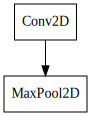

In [24]:
#$HIDE#
from graphviz import Digraph

b = Digraph('conv_block')

b.node("Conv2D", shape='box')
b.node("MaxPool2D", shape='box')

b.edge("Conv2D", "MaxPool2D")

b

Here, we chose to do one convolutional layers followed by a single pooling layer. You could do two, three, or even four convolutional layers, if you wanted. State-of-the-art convnet architectures do even more complicated kinds of processing in their blocks.

We will define a block as a new kind of layer. For this, Keras provides the `Layer` class. The pooling layer we'll use is a kind called *max pooling* (which we'll learn about in the next lesson). All of these perform their operations on 2-dimensional data; there are also 1D variants for things like time sequences and 3D variants for things like video.

In [1]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Layer, Conv2D, MaxPool2D

class ConvolutionalBlock(Layer):
    
    # Instantiate the layers
    def __init__(self, kernel_size, filters):
        super().__init__()
        
        # Convolutional Layer
        self.conv = Conv2D(kernel_size=kernel_size, 
                           filters=filters,
                           activation='relu',
                           padding='same')
        # Pooling Layer
        self.pool = MaxPool2D(pool_size=2)
    
    # Build the layers once the shape of the inputs is known
    def call(self, inputs):
        x = self.conv(inputs)
        x = self.pool(x)
        return x

For now, we don't need to worry about what the arguments mean -- just notice how we've structured the layers to match the diagram: a convolutional layer followed by a pooling layer.

Now let's build a small model using our new convolutional block. Once defined using the Keras `Layer` class, you can use your new block of layers just like you would any other layer.

Here is a diagram of the model we want to define:

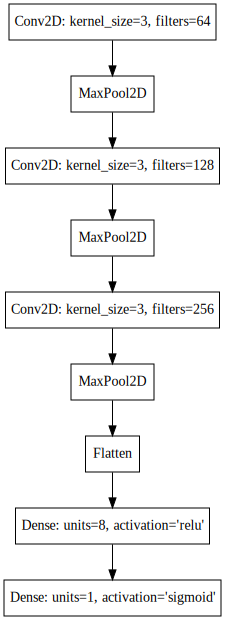

In [38]:
#$HIDE#
from graphviz import Digraph

b = Digraph('conv_model', format='png')
# b.attr(size='4,4')

b.node('conv_1', shape='box', label="Conv2D: kernel_size=3, filters=64")
b.node('pool_1', shape='box', label="MaxPool2D")
b.node('conv_2', shape='box', label="Conv2D: kernel_size=3, filters=128")
b.node('pool_2', shape='box', label="MaxPool2D")
b.node('conv_3', shape='box', label="Conv2D: kernel_size=3, filters=256")
b.node('pool_3', shape='box', label="MaxPool2D")
b.node('flat', shape='box', label="Flatten")
b.node('dense_1', shape='box', label="Dense: units=8, activation='relu'")
b.node('dense_2', shape='box', label="Dense: units=1, activation='sigmoid'")

b.edge('conv_1', 'pool_1')
b.edge('pool_1', 'conv_2')
b.edge('conv_2', 'pool_2')
b.edge('pool_2', 'conv_3')
b.edge('conv_3', 'pool_3')
b.edge('pool_3', 'flat')
b.edge('flat', 'dense_1')
b.edge('dense_1', 'dense_2')

b

We can now build it as a Keras `Sequential` model. We'll stack a couple of dense layers on top for a classifier just like we did with the model in the previous lesson.

In [2]:
import tensorflow.keras.layers as layers

model = Sequential([
    ConvolutionalBlock(kernel_size=3, filters=64),
    ConvolutionalBlock(kernel_size=3, filters=128),
    ConvolutionalBlock(kernel_size=3, filters=256),
    layers.Flatten(),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

And now we've built our own custom convnet!

To get a summary, we need to build the model first, and to build the model, we need to let Keras know what shape to expect for the input. If you were to train your model at this point, you could let Keras figure the shape out automatically from your training data instead.

In [3]:
model.build(input_shape=(192, 192, 3)) # [batches, width, height, channels]
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
convolutional_block (Convolu multiple                  38720     
_________________________________________________________________
convolutional_block_1 (Convo multiple                  221440    
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  89719296  
_________________________________________________________________
dense_1 (Dense)              multiple                  513       
Total params: 89,979,969
Trainable params: 89,979,969
Non-trainable params: 0
_________________________________________________________________


# Conclusion #

To be efficient, a neural network needs a structure that reflects the problem it is trying to solve. Modern neural networks have been designed to solve complex problems, and their architectures have become complex as a result. Designing a network around modular components like we have in this lesson makes managing this complexity much easier. (It is a kind of object-oriented design for neural networks!)

Nonetheless, a deep stack of convolutional blocks like we defined above was state-of-the-art only a few years ago, and a relatively simple model can still be the right choice with smaller datasets, when a larger model might be in danger of overfitting. Having composable blocks makes it easier to design a network to suit your need.